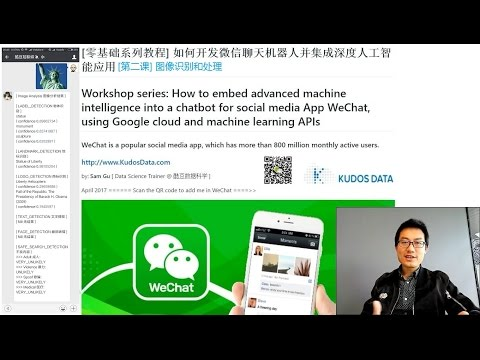

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('FPgo-hI7OiE')

# 如何使用和开发微信聊天机器人的系列教程
# A workshop to develop & use an intelligent and interactive chat-bot in WeChat

### WeChat is a popular social media app, which has more than 800 million monthly active users.

<img src='http://www.kudosdata.com/wp-content/uploads/2016/11/cropped-KudosLogo1.png' width=30% style="float: right;">
<img src='reference/WeChat_SamGu_QR.png' width=10% style="float: right;">

### http://www.KudosData.com

by: Sam.Gu@KudosData.com


May 2017 ========== Scan the QR code to become trainer's friend in WeChat ========>>

### 第五课：视频识别和处理
### Lesson 5: Video Recognition & Processing
* 识别视频的场景片段 (Detect shots change in video)
* 识别视频消息中的物体名字 (Recognize objects in video/shots)
* 直接搜索视频内容 (Search content in video)

### Using Google Cloud Platform's Machine Learning APIs

From the same API console, choose "Dashboard" on the left-hand menu and "Enable API".

Enable the following APIs for your project (search for them) if they are not already enabled:
<ol>
<li> Google Cloud Vision API </li>
<li> Google Cloud Speech API </li>
<li> Google Cloud Translate API </li>
<li> Google Cloud Natural Language API </li>
<li> Google Cloud Video API </li>
</ol>

Finally, because we are calling the APIs from Python (clients in many other languages are available), let's install the Python package (it's not installed by default on Datalab)

In [2]:
# Copyright 2016 Google Inc.
# Licensed under the Apache License, Version 2.0 (the "License"); 
# !pip install --upgrade google
# !pip install --upgrade google-api-python-client
# !pip install --upgrade google.appengine

### 导入需要用到的一些功能程序库：

In [3]:
import io, os, subprocess, sys, time, datetime, requests, itchat
from itchat.content import *
from googleapiclient.discovery import build

In [4]:
import json, numpy as np
from IPython.display import HTML
# Python 2
if sys.version_info[0] < 3:
    import urllib2
# Python 3
else:
    import urllib.request

### Using Google Cloud Platform's Machine Learning APIs

First, visit <a href="http://console.cloud.google.com/apis">API console</a>, choose "Credentials" on the left-hand menu.  Choose "Create Credentials" and generate an API key for your application. You should probably restrict it by IP address to prevent abuse, but for now, just  leave that field blank and delete the API key after trying out this demo.

Copy-paste your API Key here:

In [5]:
# Here I read in my own API_KEY from a file, which is not shared in Github repository:
with io.open('../../../API_KEY.txt') as fp: 
    for line in fp: APIKEY = line

# You need to un-comment below line and replace 'APIKEY' variable with your own GCP API key:
# APIKEY='AIzaSyCvxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [6]:
# Below is for GCP Video API
# video_service = build('videointelligence', 'v1', developerKey=APIKEY)
video_service = build('videointelligence', 'v1beta1', developerKey=APIKEY)
# check video processing progress
video_operation_service = build('videointelligence', 'v1', developerKey=APIKEY)

### 多媒体文件的二进制base64码转换 (Define image pre-processing functions)

In [7]:
# Import the base64 encoding library.
import base64
# Pass the media data to an encoding function.
def encode_media(media_file):
    with io.open(media_file, "rb") as media_file:
        media_content = media_file.read()
# Python 2
    if sys.version_info[0] < 3:
#         return base64.b64encode(media_content)
        return base64.b64encode(media_content).decode('ascii')
# Python 3
    else:
        return base64.b64encode(media_content).decode('utf-8')


### 机器智能API接口控制参数 (Define control parameters for API)

In [10]:
# API control parameter for 视频识别和处理 Video Recognition & Processing
parm_video_api_features = ['LABEL_DETECTION', 'SHOT_CHANGE_DETECTION']
# parm_video_api_features = ['LABEL_DETECTION']
# parm_video_api_features = ['SHOT_CHANGE_DETECTION']
parm_video_api_display_seconds = True # Ture: use seconds for display; False: use micro sconds for display

### Define utility function to call Video API:

In [9]:
# Envoke Video API

def KudosData_VIDEO_DETECTION(video_base64):
    print ('[INFOR] Start Video Analysis...')
##########################################################################################
# 1. Send request for video processing
##########################################################################################
    request1 = video_service.videos().annotate(body={
#               "inputUri": string,
              "inputContent": video_base64,
              "features": parm_video_api_features, # 'LABEL_DETECTION' & 'SHOT_CHANGE_DETECTION'
        })
    responses1 = request1.execute(num_retries=3)
    
    if 'name' in responses1: 
        print ('Internal video/operation name assinged : %s' % responses1['name'])
##########################################################################################
# 2. Check progress till completion (Video requires asynchronous long processing...)
##########################################################################################
        responses2 = KudosData_VIDEO_DETECTION_CHECK_PROCRESS(responses1['name'], APIKEY)
    else:
        print ('[ERROR] Calling Video API request failed. Please re-try.')
    
    return responses2

### Define utility function to check progress of Video API:

In [11]:
# Keep checking progress of Video API processing, till fully completed.

def KudosData_VIDEO_DETECTION_CHECK_PROCRESS(name, apikey):
    flag_completion = False
    operation_url = 'https://videointelligence.googleapis.com/v1/operations/' + name + '?key=' + apikey
#     print('operation_url : ', operation_url)
    while not flag_completion:
        # Python 2
        if sys.version_info[0] < 3:
            response_operation = json.loads(urllib2.urlopen(operation_url).read())
        # Python 3
        else:
#             response_operation = json.loads(urllib.request.urlopen(operation_url).read())
            response_operation = json.loads(urllib.request.urlopen(operation_url).read().decode('utf-8'))
        
        # define an array, containing 'progress %' of each Video API
        video_api_progress_pct = np.zeros(shape=(1, len(response_operation['metadata']['annotationProgress'])))
#         print('... length : %d' % len(response_operation['metadata']['annotationProgress']))
        for i in range(len(response_operation['metadata']['annotationProgress'])):
            if 'progressPercent' in response_operation['metadata']['annotationProgress'][i]:
                video_api_progress_pct[0][i] = response_operation['metadata']['annotationProgress'][i]['progressPercent']
#                 print ('>>> Video API {} Progress : {} %'.format(i+1, video_api_progress_pct[0][i]))
        print ('  overall progress : {} %'.format(np.mean(video_api_progress_pct[0])))
        if min(video_api_progress_pct[0]) == 100: 
            flag_completion = True
            print ('  Video API Completed !\n')

        time.sleep(3)
#         print('... time.sleep')

    return response_operation

In [14]:
# video_file = 'reference/video.mp4'
# video_file = 'reference/video2.mp4'
video_file = 'reference/video_kudos_data.mp4'
# video_file = 'reference/SampleVideo_360x240_1mb.mp4'
# video_file = 'reference/SampleVideo_360x240_2mb.mp4'

In [15]:
HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
         .format(encode_media(video_file)))

### Here we call Video API through our defined function:

In [16]:
video_response = KudosData_VIDEO_DETECTION(encode_media(video_file))

[INFOR] Start Video Analysis...
Internal video/operation name assinged : asia-east1.8092993946157001202
  overall progress : 0.0 %
  overall progress : 100.0 %
  Video API Completed !



### View results:

In [17]:
video_response
# video_response['response']['annotationResults'][0]

{'done': True,
 'metadata': {'@type': 'type.googleapis.com/google.cloud.videointelligence.v1beta1.AnnotateVideoProgress',
  'annotationProgress': [{'progressPercent': 100,
    'startTime': '2017-06-06T04:11:42.671527Z',
    'updateTime': '2017-06-06T04:11:45.980447Z'},
   {'progressPercent': 100,
    'startTime': '2017-06-06T04:11:42.671527Z',
    'updateTime': '2017-06-06T04:11:46.380604Z'}]},
 'name': 'asia-east1.8092993946157001202',
 'response': {'@type': 'type.googleapis.com/google.cloud.videointelligence.v1beta1.AnnotateVideoResponse',
  'annotationResults': [{'labelAnnotations': [{'description': 'City council',
      'languageCode': 'en-us',
      'locations': [{'confidence': 0.5640747,
        'level': 'VIDEO_LEVEL',
        'segment': {'endTimeOffset': '-1', 'startTimeOffset': '-1'}},
       {'confidence': 0.5640747,
        'level': 'SHOT_LEVEL',
        'segment': {'endTimeOffset': '23708345',
         'startTimeOffset': '83330'}}]},
     {'description': 'Communication',
   

In [18]:
# metadata in response: Version of Video API used; Differenc Video APIs called, and start/end processing time.
video_response['metadata']

{'@type': 'type.googleapis.com/google.cloud.videointelligence.v1beta1.AnnotateVideoProgress',
 'annotationProgress': [{'progressPercent': 100,
   'startTime': '2017-06-06T04:11:42.671527Z',
   'updateTime': '2017-06-06T04:11:45.980447Z'},
  {'progressPercent': 100,
   'startTime': '2017-06-06T04:11:42.671527Z',
   'updateTime': '2017-06-06T04:11:46.380604Z'}]}

<font color='blue'>< Start of interactive demo ></font>

### * 识别视频的场景片段 (Detect shots change in video)

In [ ]:
# video_response['response']['annotationResults'][0]['shotAnnotations']

In [19]:
if parm_video_api_display_seconds: # our pre-defined control parm
    parm_denominator = 1000000 # dispay results in seconds
else:
    parm_denominator = 1  # dispay results in microseconds

print(u'[ 视频场景片段 ]')
print('Number of scenery/shots detected : {}'.format(len(video_response['response']['annotationResults'][0]['shotAnnotations'])))
for i in range(len(video_response['response']['annotationResults'][0]['shotAnnotations'])):
#     print(video_response['response']['annotationResults'][0]['shotAnnotations'][i]) 
    if i == 0:
        print('Shot 1 : 0 ~ {} {}'
            .format(
                int(video_response['response']['annotationResults'][0]['shotAnnotations'][i]['endTimeOffset'])/parm_denominator
              , 'seconds' if parm_video_api_display_seconds else 'microseconds'
            ))
    else:
        print('Shot {} : {} ~ {} {}'
            .format(i+1
              , int(video_response['response']['annotationResults'][0]['shotAnnotations'][i]['startTimeOffset'])/parm_denominator
              , int(video_response['response']['annotationResults'][0]['shotAnnotations'][i]['endTimeOffset'])/parm_denominator
              , 'seconds' if parm_video_api_display_seconds else 'microseconds'
            ))


[ 视频场景片段 ]
Number of scenery/shots detected : 1
Shot 1 : 0 ~ 23.708345 seconds


### * 识别视频消息中的物体名字 (Recognize objects in video/shots)

In [20]:
# video_response['response']['annotationResults'][0]['labelAnnotations']

In [21]:
print(u'[ 视频物体识别 ]')
print('Number of objects detected : {}'.format(len(video_response['response']['annotationResults'][0]['labelAnnotations'])))
print('')
for i in range(len(video_response['response']['annotationResults'][0]['labelAnnotations'])):
    # print each object's name:
    print('Object {} : {}'.format(
              i+1
            , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['description']
        ))

[ 视频物体识别 ]
Number of objects detected : 14

Object 1 : City council
Object 2 : Communication
Object 3 : Conference hall
Object 4 : Conversation
Object 5 : Interview
Object 6 : Lecture
Object 7 : Management
Object 8 : Meeting
Object 9 : News conference
Object 10 : Presentation
Object 11 : Public Relations
Object 12 : Public speaking
Object 13 : Seminar
Object 14 : Speech


In [22]:
print(u'[ 视频物体识别 ]')
print('Number of objects detected : {}'.format(len(video_response['response']['annotationResults'][0]['labelAnnotations'])))

for i in range(len(video_response['response']['annotationResults'][0]['labelAnnotations'])):
    # print each object's name:
    print('')
    print('Object {} : {} [{}] Locations'.format(
              i+1
            , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['description']
            , len(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])
        ))
    
        # print each object's location in video:
    for j in range(len(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])):
#         print(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j])
        print('      [{}] Confidence : {} | {} | {} '.format(
              j+1
            , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['confidence']
            , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['level']
            , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['segment']
              ))
  

[ 视频物体识别 ]
Number of objects detected : 14

Object 1 : City council [2] Locations
      [1] Confidence : 0.5640747 | VIDEO_LEVEL | {'startTimeOffset': '-1', 'endTimeOffset': '-1'} 
      [2] Confidence : 0.5640747 | SHOT_LEVEL | {'startTimeOffset': '83330', 'endTimeOffset': '23708345'} 

Object 2 : Communication [2] Locations
      [1] Confidence : 0.4286804 | VIDEO_LEVEL | {'startTimeOffset': '-1', 'endTimeOffset': '-1'} 
      [2] Confidence : 0.4286804 | SHOT_LEVEL | {'startTimeOffset': '83330', 'endTimeOffset': '23708345'} 

Object 3 : Conference hall [2] Locations
      [1] Confidence : 0.5524731 | VIDEO_LEVEL | {'startTimeOffset': '-1', 'endTimeOffset': '-1'} 
      [2] Confidence : 0.5524731 | SHOT_LEVEL | {'startTimeOffset': '83330', 'endTimeOffset': '23708345'} 

Object 4 : Conversation [2] Locations
      [1] Confidence : 0.7613206 | VIDEO_LEVEL | {'startTimeOffset': '-1', 'endTimeOffset': '-1'} 
      [2] Confidence : 0.7613206 | SHOT_LEVEL | {'startTimeOffset': '83330', 'en

### * 直接搜索视频内容 (Search content in video)

In [23]:
search_object = 'Animal'

In [24]:
search_object = 'Toy'

In [25]:
print(u'[ 搜索视频内容 ]')
print('Look for object : %s' % search_object)

for i in range(len(video_response['response']['annotationResults'][0]['labelAnnotations'])):
    if video_response['response']['annotationResults'][0]['labelAnnotations'][i]['description'] == search_object: 
        print('Found [{}] Locations'.format(
                len(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])
            ))
        
        for j in range(len(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])):
#             print(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j])
            print('      [{}] Confidence : {} | {} | {} '.format(
                  j+1
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['confidence']
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['level']
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['segment']
                  ))


[ 搜索视频内容 ]
Look for object : Toy


In [26]:
search_object = 'Sky'

In [27]:
search_object = 'LEGO'

In [28]:
print(u'[ 搜索视频内容 ]')
print('Look for object : %s' % search_object)

for i in range(len(video_response['response']['annotationResults'][0]['labelAnnotations'])):
    if video_response['response']['annotationResults'][0]['labelAnnotations'][i]['description'] == search_object: 
        print('Found [{}] Locations'.format(
                len(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])
            ))
        
        for j in range(len(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])):
#             print(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j])
            print('      [{}] Confidence : {} | {} | {} '.format(
                  j+1
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['confidence']
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['level']
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['segment']
                  ))


[ 搜索视频内容 ]
Look for object : LEGO


In [29]:
search_object = 'Sam'

In [30]:
print(u'[ 搜索视频内容 ]')
print('Look for object : %s' % search_object)

for i in range(len(video_response['response']['annotationResults'][0]['labelAnnotations'])):
    if video_response['response']['annotationResults'][0]['labelAnnotations'][i]['description'] == search_object: 
        print('Found [{}] Locations'.format(
                len(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])
            ))
        
        for j in range(len(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])):
#             print(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j])
            print('      [{}] Confidence : {} | {} | {} '.format(
                  j+1
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['confidence']
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['level']
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['segment']
                  ))


[ 搜索视频内容 ]
Look for object : Sam


### simple score integration: Certainty Factor

CF = CF1 + CF2 * ( 1 - CF1 )

In [31]:
def KudosData_CF(cf1, cf2): return cf1 + cf2 * ( 1 - cf1)

# 1mb video

### Joint search keywords: **Animal & Sky**

[ 搜索视频内容 ] **'Animal'**
*   [2] Confidence : 0.89243287 | SHOT_LEVEL | {u'endTimeOffset': u'8333309'} 
*   [3] Confidence : 0.53296655 | SHOT_LEVEL | {u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'}
*   <font color='grey'>[1] Confidence : 0.89243287 | VIDEO_LEVEL | {u'endTimeOffset': u'-1', u'startTimeOffset': u'-1'} </font>

[ 搜索视频内容 ] **'Sky'**
*   [1] Confidence : 0.8383573 | SHOT_LEVEL | {u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'} 


In [ ]:
# {u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'}
KudosData_CF(0.53296655, 0.8383573)

<font color='blue'>Above combined score is now higher than the 'Animal only' top score: 0.89243287</font>

**Top 1. Animal & Sky**


{u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'} 



0.924507452151685


**Top 2. Animal & Sky**


{u'endTimeOffset': u'8333309'} 


0.89243287


In [ ]:
HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
     .format(encode_media(video_file)))

---

# 2mb video

### Joint search keywords: **Animal & Sky**

[ 搜索视频内容 ] **'Animal'**
*   [2] Confidence : 0.89243287 | SHOT_LEVEL | {u'endTimeOffset': u'8333309'} 
*   [5] Confidence : 0.8764819 | SHOT_LEVEL | {u'endTimeOffset': u'23533281', u'startTimeOffset': u'21733318'} 
*   [6] Confidence : 0.82209057 | SHOT_LEVEL | {u'endTimeOffset': u'25666689', u'startTimeOffset': u'23599970'} 
*   [4] Confidence : 0.7916033 | SHOT_LEVEL | {u'endTimeOffset': u'15999984', u'startTimeOffset': u'13000003'} 
*   [3] Confidence : 0.4363379 | SHOT_LEVEL | {u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'} 
*   <font color='grey'>[1] Confidence : 0.8764819 | VIDEO_LEVEL | {u'endTimeOffset': u'-1', u'startTimeOffset': u'-1'}</font>

[ 搜索视频内容 ] **'Sky'**
*   [1] Confidence : 0.81967264 | SHOT_LEVEL | {u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'} 
*   [2] Confidence : 0.496 | SHOT_LEVEL | {u'endTimeOffset': u'23533281', u'startTimeOffset': u'21733318'} 


In [ ]:
# {u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'} 
KudosData_CF(0.4363379, 0.81967264)

# This is: Top 2. Animal & Sky

In [ ]:
# {u'endTimeOffset': u'23533281', u'startTimeOffset': u'21733318'} 
KudosData_CF(0.8764819, 0.496)

# This is: Top 1. Animal & Sky

**Top 1. Animal & Sky**


{u'endTimeOffset': u'23533281', u'startTimeOffset': u'21733318'} 


0.9377468776

**Top 2. Animal & Sky**


{u'endTimeOffset': u'12933314', u'startTimeOffset': u'8399998'} 



0.898356301574944

**Top 3. Animal Only**


{u'endTimeOffset': u'8333309'} 


0.89243287


**Top 4. Animal Only**


{u'endTimeOffset': u'25666689', u'startTimeOffset': u'23599970'} 


0.82209057


In [ ]:
HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
     .format(encode_media(video_file)))

<font color='blue'>< End of interactive demo ></font>

### 定义一个输出为视频分析结果的文本消息的小功能，用于微信回复：

In [ ]:
def KudosData_video_generate_reply(video_response):
    video_reply = u'[ Video Analysis 视频分析结果 ]'
    
    # 1. 识别视频的场景片段 (Detect shots change in video)
    if parm_video_api_display_seconds: # our pre-defined control parm
        parm_denominator = 1000000 # dispay results in seconds
    else:
        parm_denominator = 1  # dispay results in microseconds

    video_reply += '\n' + (u'\n[ 视频场景片段 ]')
    video_reply += '\n' + ('Number of scenery/shot detected : {}'
                           .format(len(video_response['response']['annotationResults'][0]['shotAnnotations'])))
    for i in range(len(video_response['response']['annotationResults'][0]['shotAnnotations'])):
    #     video_reply += (video_response['response']['annotationResults'][0]['shotAnnotations'][i]) 
        if i == 0:
            video_reply += '\n' + ('Shot 1 : 0 ~ {} {}'
                .format(
                    int(video_response['response']['annotationResults'][0]['shotAnnotations'][i]['endTimeOffset'])
                    /parm_denominator
                  , 'seconds' if parm_video_api_display_seconds else 'microseconds'
                ))
        else:
            video_reply += '\n' + ('Shot {} : {} ~ {} {}'
                .format(i+1
                  , int(video_response['response']['annotationResults'][0]['shotAnnotations'][i]['startTimeOffset'])
                        /parm_denominator
                  , int(video_response['response']['annotationResults'][0]['shotAnnotations'][i]['endTimeOffset'])
                        /parm_denominator
                  , 'seconds' if parm_video_api_display_seconds else 'microseconds'
                ))

    
    # 2. 识别视频消息中的物体名字 (Recognize objects in video/shots)
    
    video_reply += '\n' + (u'\n[ 视频物体识别 ]')
    video_reply += '\n' + ('Number of objects detected : {}'
                    .format(len(video_response['response']['annotationResults'][0]['labelAnnotations'])))

    for i in range(len(video_response['response']['annotationResults'][0]['labelAnnotations'])):
        # video_reply +=  each object's name:
        video_reply += '\n'
        video_reply += '\n' + ('Object {} : {} [{}] Locations'.format(
                  i+1
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['description']
                , len(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])
            ))

            # video_reply +=  each object's location in video:
        for j in range(len(video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'])):
    #         video_reply += (video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j])
            video_reply += '\n' + ('      [{}] Confidence : {} | {} | {} '.format(
                  j+1
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['confidence']
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['level']
                , video_response['response']['annotationResults'][0]['labelAnnotations'][i]['locations'][j]['segment']
                  ))

    return video_reply

In [ ]:
print(KudosData_video_generate_reply(video_response))

# WIP - end

### 用微信App扫QR码图片来自动登录

In [ ]:
itchat.auto_login(hotReload=True) # hotReload=True: 退出程序后暂存登陆状态。即使程序关闭，一定时间内重新开启也可以不用重新扫码。
# itchat.auto_login(enableCmdQR=-2) # enableCmdQR=-2: 命令行显示QR图片

In [ ]:
# @itchat.msg_register([VIDEO], isGroupChat=True)
@itchat.msg_register([VIDEO])
def download_files(msg):
    msg.download(msg.fileName)
    print('\nDownloaded video file name is: %s' % msg['FileName'])
    ##############################################################################################################
    #                                          call video analysis APIs                                          #
    ##############################################################################################################
    video_response = KudosData_VIDEO_DETECTION(encode_media(msg['FileName']))
    ##############################################################################################################
    #                                          format video API results                                          #
    ##############################################################################################################
    video_analysis_reply = KudosData_video_generate_reply(video_response)
    print(video_analysis_reply)
    return video_analysis_reply

In [ ]:
itchat.run()

In [ ]:
# interupt kernel, then logout
itchat.logout() # 安全退出

### 恭喜您！已经完成了：
### 第五课：视频识别和处理
### Lesson 5: Video Recognition & Processing
* 识别视频的场景片段 (Detect shots change in video)
* 识别视频消息中的物体名字 (Recognize objects in video/shots)
* 直接搜索视频内容 (Search content in video)

### 下一课是:
### 第六课：互动智能机器人应用
### Lesson 6: Intelligent & Interactive Chat-bot Applications
* 多语言翻译器 (Language translator)
* 图文多媒体的订阅和点播 (Multi-media broadcast & on-demand subscription)
* 文章的概括和缩写 (Automatic article summary)
* 不良图片的识别；不良视频片段的自动识别和定位 (Explicit content detector: i.e. adult content or violent content)
* 基于商品图片的搜索和商家价格比较 (Best retail price finder using an image of goods)

<img src='http://www.kudosdata.com/wp-content/uploads/2016/11/cropped-KudosLogo1.png' width=30% style="float: right;">
<img src='reference/WeChat_SamGu_QR.png' width=10% style="float: left;">

